In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy.io as sio
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations
from prettytable import PrettyTable


%matplotlib inline

In [2]:
def logistic(x, min_val, max_val, k=1):
    x0 = (min_val+max_val)/2
    return 1/(1 + np.exp(-k*(x-x0)))
#     return np.exp(x0+ k*x)/(1 + np.exp(x0+ k*x))

In [3]:
def heart_data():
    data = pd.read_csv('data/processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_car():
    data = pd.read_csv('data/car.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    cols = list(data.columns)
    
    data = data.groupby(cols[-1]).filter(lambda x: len(x) > 2)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def wine_quality_white():
#     data = pd.read_csv('data/winequality-red.csv', sep=';')
    data = pd.read_csv('data/winequality-white.csv', sep=';')
    cols = list(data.columns)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def wine_quality_red():
    data = pd.read_csv('data/winequality-red.csv', sep=';')
    cols = list(data.columns)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_adult():
    data = pd.read_csv('data/adult.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_abalone():
    data = pd.read_csv('data/abalone.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    cols = list(data.columns)
    
    data = data.groupby(cols[-1]).filter(lambda x: len(x) > 2)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data
    

def load_mat(mat_file):
    data = sio.loadmat(mat_file)
    data = np.concatenate((data['X'], data['Y']-1), axis=1)
#     plt.scatter(data[:300,0], data[:300,1], c='c', marker='x')
#     plt.scatter(data[300:600,0], data[300:600,1], c='b', marker='x')
#     plt.scatter(data[900:1200,0], data[900:1200,1], c='g', marker='x')
#     plt.scatter(data[600:900,0], data[600:900,1], c='r', marker='x')
#     plt.scatter(data[1200:1500,0], data[1200:1500,1], c='y', marker='x')
#     plt.scatter(data[1500:1800,0], data[1500:1800,1], c='m', marker='x')
#     plt.scatter(data[1800:2100,0], data[1800:2100,1], c='k', marker='x')
#     plt.scatter(data[2100:2400,0], data[2100:2400,1], marker='x')
#     plt.show()
    data = pd.DataFrame(data=data)
    return data


In [4]:
#synthetic data
def synthetic_data(p, t, n_dim=2):
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    
    q0 = p*t
    q1 = p*(t-q0)
    q2 = p*(t-q0-q1)
    q3 = p*(t-q0-q1-q2)
    q4 = t-q0-q1-q2-q3
    
    q = [np.int(q0), np.int(q1), np.int(q2), np.int(q3), np.int(q4)]
    
#     mean0 = np.ones(n_dim)*1
#     mean1 = np.ones(n_dim)*1.5
#     mean2 = np.ones(n_dim)*1.7
#     mean3 = np.ones(n_dim)*0.5
#     mean4 = np.ones(n_dim)*1.65
    
    
    mean0 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean1 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean2 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean3 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean4 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    
    
#     np.random.seed(1234)
    
    var0 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var1 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var2 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var3 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var4 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    
    #g0 = np.random.multivariate_normal(mean0, np.eye(13), size=q[0])
    #g1 = np.random.multivariate_normal(mean1, np.eye(13), size=q[1])
    #g2 = np.random.multivariate_normal(mean2, np.eye(13), size=q[2])
    #g3 = np.random.multivariate_normal(mean3, np.eye(13), size=q[3])
    #g4 = np.random.multivariate_normal(mean4, np.eye(13), size=q[4])
    
    g0 = np.random.multivariate_normal(mean0, var0, size=q[0])
    g1 = np.random.multivariate_normal(mean1, var1, size=q[1])
    g2 = np.random.multivariate_normal(mean2, var2, size=q[2])
    g3 = np.random.multivariate_normal(mean3, var3, size=q[3])
    g4 = np.random.multivariate_normal(mean4, var4, size=q[4])

    
    y0 = np.asarray([0]*q[0]).reshape(q[0],1)
    y1 = np.asarray([1]*q[1]).reshape(q[1],1)
    y2 = np.asarray([2]*q[2]).reshape(q[2],1)
    y3 = np.asarray([3]*q[3]).reshape(q[3],1)
    y4 = np.asarray([4]*q[4]).reshape(q[4],1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    
    g0 = np.concatenate((g0,y0), axis=1)
    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g0,g1,g2,g3,g4], axis=0)
    d = pd.DataFrame(data=g)

#     d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    if n_dim == 2:
        plt.scatter(g0[:,0], g0[:,1], c='c')
        plt.scatter(g1[:,0], g1[:,1], c='b')
        plt.scatter(g2[:,0], g2[:,1], c='r')
        plt.scatter(g3[:,0], g3[:,1], c='g')
        plt.scatter(g4[:,0], g4[:,1], c='y')
        plt.show()
    elif n_dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(g0[:,0], g0[:,1], g0[:,2], c='c')
        ax.scatter(g1[:,0], g1[:,1], g1[:,2], c='b')
        ax.scatter(g2[:,0], g2[:,1], g2[:,2], c='r')
        ax.scatter(g3[:,0], g3[:,1], g3[:,2], c='g')
        ax.scatter(g4[:,0], g4[:,1], g4[:,2], c='y')
        plt.show()
    
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])


In [5]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]-1
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if np.isclose(fpr[i],0.0):
            continue
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                
## https://en.wikipedia.org/wiki/Diagnostic_odds_ratio
def max_dor(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt_dor = -1
    for i in range(len(fpr)):
        dor = (se[i]/(1.0-se[i]))*(sp[i]/(1.0-sp[i]))
        if dor > opt_dor and not np.isinf(dor) and not np.isnan(dor):
            opt_dor = dor
            index = i
    return fpr[index], tpr[index]


In [100]:
class ClassifierWithRoc(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n_classes = len(np.unique(Y))
        self.n_clf = self.n_classes * (self.n_classes - 1) // 2
        self.c_groups = [(t[1],t[0]) for t in list(combinations(list(range(0,self.n_classes)),2))]
    
    def split_data(self, X, Y, min_samples=500):
        if X.shape[0] >= min_samples:
            x_train, x_test_and_val, y_train, y_test_and_val = train_test_split(X, Y, test_size=.40, stratify=Y)
            x_val, x_test, y_val, y_test = train_test_split(x_test_and_val, y_test_and_val, 
                                                            test_size=.50, stratify=y_test_and_val)
        else:
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.20, stratify=Y)
            x_val = None; y_val = None
            
        return np.asarray(x_train), np.asarray(x_val), np.asarray(x_test), np.asarray(y_train), np.asarray(y_val), np.asarray(y_test)
    
    def z_score(self, x_train):      
        scaler = preprocessing.StandardScaler().fit(x_train)
        return scaler
    
    def estimator(self, x_train, y_train, scaler):
        x_train = scaler.transform(x_train)
        ovo = OneVsOneClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), n_jobs=-1)
        ovo.fit(x_train, y_train)
        return ovo
    
    def predict(self, estimator, x_test, y_test, scaler, points=None, c=0, mode='half', clfs=None):
        modes = {'zero': 0, 'half': 0.5, 'one':1}
        x_test = scaler.transform(x_test)
        if points is None:
            y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
            votes = np.zeros(y_test_bin.shape)
#             pred = estimator.predict(x_test)
            if clfs is None:
                for i in range(self.n_clf):
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > 0:
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
            else:
                for i in clfs:
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > 0:
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
#             cm = confusion_matrix(y_test, pred)
#             acc = cm.diagonal().sum() / cm.sum()
#             return [pred, cm, acc]
        elif c < 2:
            y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
            votes = np.zeros(y_test_bin.shape)
            if clfs is None:
                for i in range(self.n_clf):
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > points[i][c] or np.isclose(p,points[i][c]):
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
            else:
                for i in clfs:
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > points[i][c] or np.isclose(p,points[i][c]):
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
        elif c == 2:
            if mode != 'logistic':
                y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
                votes = np.zeros(y_test_bin.shape)
                if clfs is None:
                    for i in range(self.n_clf):
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                votes[j, self.c_groups[i][0]] += modes[mode]
                                votes[j, self.c_groups[i][1]] += modes[mode]
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
                else:
                    for i in clfs:
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                votes[j, self.c_groups[i][0]] += modes[mode]
                                votes[j, self.c_groups[i][1]] += modes[mode]
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
            else:
                y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
                votes = np.zeros(y_test_bin.shape)
                if clfs is None:
                    for i in range(self.n_clf):
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                #adjust steepness to interval
                                #12 seeems to be a good number
                                k = 12 / (abs(max(points[i]) - min(points[i])))
                                point = logistic(p, min(points[i]), max(points[i]), k=k)
                                votes[j, self.c_groups[i][0]] += point
                                votes[j, self.c_groups[i][1]] += 1-point
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
                else:
                    for i in clfs:
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                #adjust steepness to interval
                                #12 seeems to be a good number
                                k = 12 / (abs(max(points[i]) - min(points[i])))
                                point = logistic(p, min(points[i]), max(points[i]), k=k)
                                votes[j, self.c_groups[i][0]] += point
                                votes[j, self.c_groups[i][1]] += 1-point
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
        
#         print(votes)
        occurrences = np.asarray([np.where(t==t.max())[0] for t in votes])
#         print(occurrences)
        pred = [p[-1] for p in occurrences]
        cm = confusion_matrix(y_test, pred)
        acc = cm.diagonal().sum() / cm.sum()
        return [pred, cm, acc]
        
        
    def calculate_roc(self, estimator, x_val, x_train, y_val, y_train, scaler):
        clf_index = 0
        fpr = dict(); tpr = dict(); thresholds = dict(); roc_auc = dict(); cutpoints = dict()
        x_val = scaler.transform(x_val) if x_val is not None else None
        x_train = scaler.transform(x_train)
        y_val_bin = label_binarize(y_val, classes=list(range(self.n_classes))) if y_val is not None else None
        y_train_bin = label_binarize(y_train, classes=list(range(self.n_classes)))
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                if j > i:
                    clf = estimator.estimators_[clf_index]
                    if y_val_bin is not None and x_val is not None:
                        proba = clf.decision_function(x_val)
                        fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_val_bin[:, i]-1),
                                                                                          proba)
                    else:
                        proba = clf.decision_function(x_train)
                        fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_train_bin[:, i]-1),
                                                                                          proba)
                    roc_auc[clf_index] = auc(fpr[clf_index], tpr[clf_index])
                    youden_cut = youden_index(fpr[clf_index], tpr[clf_index])
                    maxdor_cut = max_dor(fpr[clf_index], tpr[clf_index])
                    y_index = np.where(np.isclose(fpr[clf_index],youden_cut[0]))[0][0]
                    d_index = np.where(np.isclose(fpr[clf_index],maxdor_cut[0]))[0][0]
                    if y_index == 0:
                        y_index += 1
                    if d_index == 0:
                        d_index += 1

                    cutpoints[clf_index] = np.array([thresholds[clf_index][y_index], thresholds[clf_index][d_index]])
                    clf_index += 1
        return fpr, tpr, thresholds, roc_auc, cutpoints
    
    def plot_roc(self, fpr, tpr, thresholds, roc_auc, cutpoints, show=True, save=False, clfs=None):
        range_clf = list(range(self.n_clf)) if clfs is None else clfs
        for i in range_clf:
            youden_cut = youden_index(fpr[i], tpr[i])
            maxdor_cut = max_dor(fpr[i], tpr[i])
            default = np.where(np.isclose(thresholds[i],min(thresholds[i], key=abs)))[0][0]
            fig, ax = plt.subplots(1,2, figsize=(15,7))
            lw = 2
            ax[0].plot(fpr[i], tpr[i], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
            ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
            ax[0].set_xlim([-0.05, 1.05])
            ax[0].set_ylim([-0.05, 1.05])
            ax[0].set_xlabel('False Positive Rate')
            ax[0].set_ylabel('True Positive Rate')
            ax[0].set_title('Receiver operating characteristic for class ' + str(tuple(reversed(self.c_groups[i]))))
            #ax.scatter(opt_cutpoint1[0], opt_cutpoint1[1], c='g', zorder=1, label='MaxSp cutpoint', s=50)
            #ax.scatter(opt_cutpoint2[0], opt_cutpoint2[1], c='r', zorder=1, label='MaxSe cutpoint', s=50)
            ax[0].scatter(youden_cut[0], youden_cut[1], c='b', zorder=1, label='Youden', s=50)
            ax[0].scatter(maxdor_cut[0], maxdor_cut[1], c='r', zorder=1, label='Max Dor', s=50)
            ax[0].scatter(fpr[i][default], tpr[i][default], c='g', zorder=1, label='Default', s=50)
            ax[0].legend(loc="lower right")

            ax2 = ax[0].twinx()
            ax2.plot(fpr[i], thresholds[i], color='r', lw=lw, linestyle='--', zorder=-1)
            ax2.set_ylabel('Threshold',color='r')
            ax2.set_ylim([thresholds[i][-1],thresholds[i][0]])
            ax2.set_xlim([-0.05, 1.05])

            if np.isclose(min(cutpoints[i]), max(cutpoints[i])):  
                ax[1].axis('off')
            else:
                #adjust steepness to interval
                #12 seeems to be a good number
                k = 12 / (abs(max(cutpoints[i]) - min(cutpoints[i])))

                x_range = np.arange(min(cutpoints[i]), max(cutpoints[i]), 0.0001)
                y_range = logistic(x_range, min(cutpoints[i]), max(cutpoints[i]), k=k)
                ax[1].set_title('Logistic function between cutpoints')

                ax[1].spines['left'].set_position('center')
                ax[1].spines['right'].set_color('none')
                ax[1].spines['top'].set_color('none')
                ax[1].xaxis.set_ticks_position('bottom')
                ax[1].yaxis.set_ticks_position('left')
                ax[1].plot(x_range, y_range, c='y', lw=lw, zorder=-1)
                ax[1].scatter(cutpoints[i][0], logistic(cutpoints[i][0], min(cutpoints[i]), max(cutpoints[i]), k=k), 
                              c='b', zorder=1, label='Youden', s=50)
                ax[1].scatter(cutpoints[i][1], logistic(cutpoints[i][1], min(cutpoints[i]), max(cutpoints[i]), k=k),
                              c='r', zorder=1, label='Max Dor', s=50)

                ax[1].plot([x_range[0], x_range[0]], [-0.05, y_range[0]], linestyle='--', c='k')
                ax[1].plot([x_range[-1], x_range[-1]], [-0.05, y_range[-1]], linestyle='--', c='k')
                ax[1].set_xticks(cutpoints[i], minor=False)

            
            fig.subplots_adjust(hspace=0.3, wspace=0.6, top=0.8)
            if save:
                plots_folder = os.path.join(os.getcwd(),'roc_plots')
                if not os.path.exists(plots_folder):
                    os.mkdir(plots_folder)
                plt.savefig(os.path.join(os.getcwd(), 'heart_' + str(tuple(reversed(self.c_groups[i])))) + '.png',
                            bbox_inches='tight', pad_inches=0.5)
            if show:
                plt.show()
        
        
        

In [7]:
def apply(data, times=1, clfs=None):
    cols = list(data.columns)
    Y = data[cols[-1]].copy()
    cols.remove(cols[-1])
    X = data[cols].copy()
    roc_clf = ClassifierWithRoc(X,Y)
    
    pred = []; pred_y = []; pred_dor = []; pred_zero = []; pred_half = []; pred_one = []; pred_log = []
    
    for i in tqdm(range(times)):
        x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
        scaler = roc_clf.z_score(x_train)
        est = roc_clf.estimator(x_train, y_train, scaler)
        fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                         y_train, scaler)
        pred.append(roc_clf.predict(est, x_test, y_test, scaler, clfs=clfs))
        pred_y.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=0, clfs=clfs))
        pred_dor.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=1, clfs=clfs))
        pred_zero.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='zero', clfs=clfs))
        pred_half.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='half', clfs=clfs))
        pred_one.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='one', clfs=clfs))
        pred_log.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='logistic', clfs=clfs))
#         roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints)
    
    pred = np.asarray(pred); pred_y = np.asarray(pred_y); pred_dor = np.asarray(pred_dor); 
    pred_zero = np.asarray(pred_zero); pred_half = np.asarray(pred_half); pred_one = np.asarray(pred_one); 
    pred_log = np.asarray(pred_log)
    
    return np.array([[np.mean(pred[:,2]), np.std(pred[:,2])], [np.mean(pred_y[:,2]), np.std(pred_y[:,2])], [np.mean(pred_dor[:,2]), np.std(pred_dor[:,2])],
            [np.mean(pred_zero[:,2]), np.std(pred_zero[:,2])], [np.mean(pred_half[:,2]), np.std(pred_half[:,2])], 
            [np.mean(pred_one[:,2]), np.std(pred_one[:,2])], [np.mean(pred_log[:,2]), np.std(pred_log[:,2])]])

#     print(np.mean(pred[:,2]))
#     print(np.mean(pred_y[:,2]))
#     print(np.mean(pred_dor[:,2]))
#     print(np.mean(pred_zero[:,2]))
#     print(np.mean(pred_half[:,2]))
#     print(np.mean(pred_one[:,2]))
#     print(np.mean(pred_log[:,2]))

[(1, 0), (4, 0), (5, 0), (4, 1), (5, 1), (5, 4)] 6


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


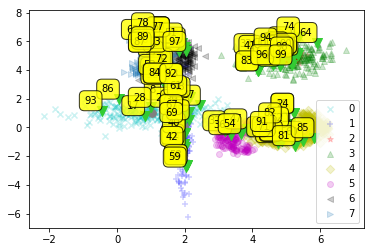

[[6, 7] [7, 6] [6, 7, 0] [6, 7, 0] [1, 0, 5] [6, 7] [7, 6] [2, 3] [0, 1]
 [7, 6] [1, 5, 0, 4] [6, 7] [2, 3] [4, 5] [4, 5, 1] [4, 5] [7, 6] [0, 1]
 [3, 2] [1, 0, 5] [6, 7] [1, 5, 0] [3, 2] [4, 5] [4, 5] [2, 3] [2, 3]
 [0, 1] [0, 1] [6, 7] [7, 6, 0] [3, 2] [5, 1, 4, 0] [3, 2, 6] [1, 5, 0, 4]
 [6, 7] [5, 1, 4] [0, 1, 5] [2, 3] [0, 1] [1, 0, 5] [3, 2] [1, 5, 0, 4]
 [7, 6] [3, 2] [1, 0, 5] [7, 6] [5, 4, 1] [0, 1] [3, 2] [6, 7] [6, 7]
 [7, 0, 6, 1] [7, 6, 0] [5, 4, 1] [2, 3] [3, 2] [4, 5, 1] [1, 5, 0, 4]
 [1, 5, 0, 4] [4, 5] [0, 1] [4, 5] [3, 2] [2, 3] [7, 6] [2, 3] [1, 0, 5]
 [4, 5, 1] [1, 0, 5] [5, 4, 1] [4, 5, 1] [6, 7] [6, 7] [2, 3] [2, 3] [2, 3]
 [6, 7] [7, 6] [6, 7, 0, 1] [7, 6] [4, 5] [4, 5] [3, 2] [6, 7, 0, 1] [4, 5]
 [0, 1] [7, 6] [2, 3] [7, 6] [2, 3] [5, 4, 1] [6, 7, 0] [0, 1] [3, 2]
 [3, 2] [3, 2] [6, 7] [2, 3] [3, 2]]


In [192]:
data = load_mat('data/synth8.mat')
c1, c2, c3, c4, c5 = data[:300], data[300:600], data[600:900], data[900:1200], data[1200:1500], 
c6, c7, c8 = data[1500:1800], data[1800:2100], data[2100:2400]

classes = np.array([[c1,'c','x'], [c2,'b','+'], [c3,'r','*'], [c4,'g','^'], [c5,'y','D'], 
           [c6,'m','o'], [c7,'k','<'], [c8,(31/255, 119/255, 180/255),'>']])

centroid1, centroid2, centroid3, centroid4 = np.mean(c1, axis=0)[:2], np.mean(c2, axis=0)[:2], np.mean(c3, axis=0)[:2], np.mean(c4, axis=0)[:2]
centroid5, centroid6, centroid7, centroid8 = np.mean(c5, axis=0)[:2], np.mean(c6, axis=0)[:2], np.mean(c7, axis=0)[:2], np.mean(c8, axis=0)[:2]

centroids = np.array([centroid1, centroid2, centroid3, centroid4, centroid5, centroid6, centroid7, centroid8])


plt.clf()
plt.cla()
plt.close()
for i, c in enumerate(classes):
    plt.scatter(c[0][0], c[0][1], c=c[1], marker=c[2], label=str(i), alpha=0.2)
    plt.scatter(centroids[i][0], centroids[i][1], c=(0.5,0.5,0.5), marker='o', s=60)
    
plt.legend(loc="lower right")


#test points

# p = np.array([[-1, 6, ]])
# p = np.array([[-1, 6]])
# p = np.array([[2, 0.5]])
# p = np.array([[3.5, 5.8]])
# p = np.array([[2.5, -5]])
# p_class = 1

# d1, d2, d3 = np.linalg.norm(p[0]-centroid1), np.linalg.norm(p[0]-centroid2), np.linalg.norm(p[0]-centroid3)
# d4, d5, d6 = np.linalg.norm(p[0]-centroid4), np.linalg.norm(p[0]-centroid5), np.linalg.norm(p[0]-centroid6)
# d7, d8 = np.linalg.norm(p[0]-centroid7), np.linalg.norm(p[0]-centroid8)

# dists = [[d1,0],[d2,1],[d3,2],[d4,3],[d5,4],[d6,5],[d7,6],[d8,7]]
# dists.sort()
# print(dists[:int(len(dists)/2)])
# chosen = np.asarray(dists[:int(len(dists)/2)])[:,1]
# print(chosen)


# plt.scatter(p[0,0], p[0,1], c=(0.2,0.8,0.2), marker='^', s=100)

# np.random.seed(1)


cols = list(data.columns)
Y = data[cols[-1]].copy()
cols.remove(cols[-1])
X = data[cols].copy()
roc_clf = ClassifierWithRoc(X,Y)
# print(roc_clf.c_groups, len(roc_clf.c_groups))
pairs = [pair for pair in roc_clf.c_groups if pair[0] in chosen and pair[1] in chosen]
clfs = [roc_clf.c_groups.index(clf) for clf in pairs]
print(pairs, len(pairs))
# print(clfs)


x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
scaler = roc_clf.z_score(x_train)
est = roc_clf.estimator(x_train, y_train, scaler)
fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                 y_train, scaler)

x_test, y_test = np.asarray(x_test), np.asarray(y_test)
test_indexes = np.random.randint(len(x_test), size=100)
p_test = x_test[test_indexes]
c_test = y_test[test_indexes]

# p_test = x_test
# c_test = y_test

#calculate distances
distances = []
for i, pt in enumerate(p_test):
    plt.scatter(pt[0], pt[1], c=(0.2,0.8,0.2), marker='v', s=100)
    plt.annotate(str(i), xy=(pt[0], pt[1]), xytext=(-5, 5), 
                 textcoords='offset points', ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', 
                                                                                fc='yellow', alpha=0.8))
    dist = []
    for j, c in enumerate(centroids):
        d = np.linalg.norm(pt-c)
        dist.append([d, j])
    dist.sort()
    distances.append(dist)


plt.show()

distances = np.asarray(distances)

c_distances = []

for dist in distances:
    c_dist = []
    for i, d in enumerate(dist):
        if i == 0:
            c_dist.append([0.0, d[1]])
            continue
        else:
            c_dist.append([d[0]-dist[0,0], d[1]])
    c_distances.append(c_dist)

c_distances = np.asarray(c_distances)

influences = []
for i, dist in enumerate(c_distances):    
    std = np.std(dist[:,0])
    influences.append(list(dist[np.where(dist[:,0] < std)[0]][:,1].astype(np.int32)))
#     plt.title("Point " + str(i))
# #     print(dist)
#     x_axis = np.arange(len(dist))
#     plt.plot(x_axis, dist[:,0])
#     plt.scatter(x_axis, dist[:,0])
#     for j, d in enumerate(dist):
#         plt.annotate(d[1], xy=(x_axis[j], d[0]), ha='right', va='bottom')
#     plt.yticks(dist[:,0])
#     plt.show()
    
influences = np.asarray(influences)
# print(c_test)

print(influences)
# influences = np.array([[0,1,6,7],[4,5], [4,5], [0,1,6,7], [3,4,5], [0,1,3,6,7], [3,6,7], [2,3], 
#                        [0,4,5], [2,3]])




In [199]:
plt.clf()
plt.cla()
plt.close()
# for j, p in enumerate(p_test):
#     plt.annotate('Point ' + str(j), xy=(p[0], p[1]), ha='left', va='top')
#     for i in influences[j]:
#         plt.plot([p[0], centroids[i,0]], [p[1], centroids[i,1]], '-o', color=classes[i,1])
#     plt.title("Influence graph for point " + str(j))
#     plt.xticks(np.arange(min(x_train[:,0]), max(x_train[:,0])))
#     plt.yticks(np.arange(min(x_train[:,1]), max(x_train[:,1])))
#     plt.show()

times = 10

acc_clf_pred = []; acc_clf_pred_y = []; acc_clf_pred_dor = []; acc_clf_pred_zero = []; acc_clf_pred_half = [];
acc_clf_pred_one = []; acc_clf_pred_log = []

acc_all_pred = []; acc_all_pred_y = []; acc_all_pred_dor = []; acc_all_pred_zero = []; acc_all_pred_half = [];
acc_all_pred_one = []; acc_all_pred_log = []

for t in tqdm(range(times)):
    x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
    scaler = roc_clf.z_score(x_train)
    est = roc_clf.estimator(x_train, y_train, scaler)
    fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                     y_train, scaler)

    x_test, y_test = np.asarray(x_test), np.asarray(y_test)
    test_indexes = np.random.randint(len(x_test), size=100)
    p_test = x_test[test_indexes]
    c_test = y_test[test_indexes]
    
    #calculate distances
    distances = []
    for i, pt in enumerate(p_test):
        dist = []
        for j, c in enumerate(centroids):
            d = np.linalg.norm(pt-c)
            dist.append([d, j])
        dist.sort()
        distances.append(dist)

    distances = np.asarray(distances)

    c_distances = []

    for dist in distances:
        c_dist = []
        for i, d in enumerate(dist):
            if i == 0:
                c_dist.append([0.0, d[1]])
                continue
            else:
                c_dist.append([d[0]-dist[0,0], d[1]])
        c_distances.append(c_dist)

    c_distances = np.asarray(c_distances)

    influences = []
    for i, dist in enumerate(c_distances):    
        std = np.std(dist[:,0])
        influences.append(list(dist[np.where(dist[:,0] < std)[0]][:,1].astype(np.int32)))

    influences = np.asarray(influences)
    
    t_1 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

    clf_pred = []; clf_pred_y = []; clf_pred_dor = []; clf_pred_zero = []; clf_pred_half = []; clf_pred_one = []; 
    clf_pred_log = []

    for i, inf in enumerate(influences):  
        pairs = [pair for pair in roc_clf.c_groups if pair[0] in inf and pair[1] in inf]
        clfs = [roc_clf.c_groups.index(clf) for clf in pairs]
        pred = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, clfs=clfs)
        pred_y = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=0, clfs=clfs)
        pred_dor = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=1, clfs=clfs)
        pred_zero = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='zero', clfs=clfs)
        pred_half = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='half', clfs=clfs)
        pred_one = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='one', clfs=clfs)
        pred_log = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='logistic', clfs=clfs)


        clf_pred.append(pred[0]); clf_pred_y.append(pred_y[0]); clf_pred_dor.append(pred_dor[0]); clf_pred_zero.append(pred_zero[0]);
        clf_pred_half.append(pred_half[0]); clf_pred_one.append(pred_one[0]); clf_pred_log.append(pred_log[0]);

        t_1.add_row([i, c_test[i], pred[0], pred_y[0], pred_dor[0], pred_zero[0], pred_half[0], pred_one[0], pred_log[0]])    
    #     print(20*"#" + " Point " + str(i) + " " + 20*"#")
    #     roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints, clfs=clfs)
    # print(t_1)

    t_2 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

    all_pred = []; all_pred_y = []; all_pred_dor = []; all_pred_zero = []; all_pred_half = []; all_pred_one = []; 
    all_pred_log = []

    for i, p in enumerate(p_test):
        pred = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler)
        pred_y = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=0)
        pred_dor = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=1)
        pred_zero = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='zero')
        pred_half = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='half')
        pred_one = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='one')
        pred_log = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='logistic')


        all_pred.append(pred[0]); all_pred_y.append(pred_y[0]); all_pred_dor.append(pred_dor[0]); all_pred_zero.append(pred_zero[0]);
        all_pred_half.append(pred_half[0]); all_pred_one.append(pred_one[0]); all_pred_log.append(pred_log[0]);

        t_2.add_row([i, c_test[i], pred[0], pred_y[0], pred_dor[0], pred_zero[0], pred_half[0], pred_one[0], pred_log[0]])   
    
    
    acc_clf_pred.append(accuracy_score(c_test, clf_pred)); acc_clf_pred_y.append(accuracy_score(c_test, clf_pred_y)); 
    acc_clf_pred_dor.append(accuracy_score(c_test, clf_pred_dor)); acc_clf_pred_zero.append(accuracy_score(c_test, clf_pred_zero)); 
    acc_clf_pred_half.append(accuracy_score(c_test, clf_pred_half)); acc_clf_pred_one.append(accuracy_score(c_test, clf_pred_one)); 
    acc_clf_pred_log.append(accuracy_score(c_test, clf_pred_log))
    
    acc_all_pred.append(accuracy_score(c_test, all_pred)); acc_all_pred_y.append(accuracy_score(c_test, all_pred_y)); 
    acc_all_pred_dor.append(accuracy_score(c_test, all_pred_dor)); acc_all_pred_zero.append(accuracy_score(c_test, all_pred_zero)); 
    acc_all_pred_half.append(accuracy_score(c_test, all_pred_half)); acc_all_pred_one.append(accuracy_score(c_test, all_pred_one)); 
    acc_all_pred_log.append(accuracy_score(c_test, all_pred_log))
                                                                                            
t_3 = PrettyTable()
t_3.add_column('With all clf mean', [np.mean(acc_all_pred), np.mean(acc_all_pred_y),
                                     np.mean(acc_all_pred_dor), np.mean(acc_all_pred_zero), 
                                     np.mean(acc_all_pred_half), np.mean(acc_all_pred_one),
                                     np.mean(acc_all_pred_log)])
                                                                                            
t_3.add_column('With all clf std', [np.std(acc_all_pred), np.std(acc_all_pred_y),
                                    np.std(acc_all_pred_dor), np.std(acc_all_pred_zero), 
                                    np.std(acc_all_pred_half), np.std(acc_all_pred_one),
                                    np.std(acc_all_pred_log)])

t_3.add_column('With filtered clf mean', [np.mean(acc_clf_pred), np.mean(acc_clf_pred_y),
                                          np.mean(acc_clf_pred_dor), np.mean(acc_clf_pred_zero), 
                                          np.mean(acc_clf_pred_half), np.mean(acc_clf_pred_one),
                                          np.mean(acc_clf_pred_log)])

t_3.add_column('With filtered clf std', [np.std(acc_clf_pred), np.std(acc_clf_pred_y),
                                         np.std(acc_clf_pred_dor), np.std(acc_clf_pred_zero), 
                                         np.std(acc_clf_pred_half), np.std(acc_clf_pred_one),
                                         np.std(acc_clf_pred_log)])

# print(t_2)

print(t_3)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:35<00:00,  3.42s/it]

+-------------------+------------------+------------------------+-----------------------+
| With all clf mean | With all clf std | With filtered clf mean | With filtered clf std |
+-------------------+------------------+------------------------+-----------------------+
|       0.765       | 0.0478016736109  |         0.761          |     0.044821869662    |
|       0.688       | 0.0331058907145  |         0.641          |    0.0410974451761    |
|       0.641       | 0.0533760245803  |         0.623          |    0.0562227711875    |
|       0.672       | 0.0526877594893  |         0.604          |    0.0708801805867    |
|       0.691       | 0.0406078810085  |         0.654          |    0.0557135531087    |
|        0.68       | 0.0495983870705  |         0.653          |     0.051778373864    |
|       0.722       |  0.033406586177  |         0.689          |    0.0385875627631    |
+-------------------+------------------+------------------------+-----------------------+


In [8]:
datasets = [heart_data(), load_car(), wine_quality_red(), wine_quality_white(), load_abalone(), 
            load_mat('data/synth8.mat'), load_mat('data/synth8_unbalanced.mat')]

cols = ['dataset', 'mean acc', 'std', 'mean acc yoden', 'std yoden', 'mean acc max dor', 'std max dor',
        'mean acc both zero', 'std both zero', 'mean acc both half', 'std both half',
        'mean acc both one', 'std both one', 'mean acc both logistic', 'std both logistic']
names = [['heart'], ['car'], ['red wine quality'], ['white wine quality'], ['abalone'], ['synth8'],
         ['unbalanced synth8']]

d_rows = []

times = 10
for d in datasets:
    d_rows.append(apply(d, times).ravel())
d_rows = np.asarray(d_rows)
d_rows = np.concatenate((names, d_rows), axis=1)
df = pd.DataFrame(data=np.asarray(d_rows), columns=cols)
df
# data = heart_data()
# data = load_adult()
# data = wine_quality_red()
# data = wine_quality_white()
# data = load_abalone()
# data = load_mat('data/synth8.mat')
# data = load_mat('data/synth8_unbalanced.mat')

# data = heart_data()
# apply(data).ravel()

  0%|          | 0/10 [00:00<?, ?it/s]/home/gmatos/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/home/gmatos/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


,dataset,mean acc,std,mean acc yoden,std yoden,mean acc max dor,std max dor,mean acc both zero,std both zero,mean acc both half,std both half,mean acc both one,std both one,mean acc both logistic,std both logistic
0,heart,0.495,0.07151145984308312,0.48500000000000004,0.07243771270700244,0.43,0.08491826135237998,0.4466666666666666,0.07408703590297624,0.4883333333333334,0.06710274046399134,0.4566666666666667,0.07118052168020873,0.49833333333333335,0.06808899405271833
1,car,0.5138728323699422,0.021269791321357343,0.49479768786127176,0.04319431605148997,0.43641618497109824,0.09695659531936453,0.47485549132947974,0.07022645622458923,0.4765895953757225,0.06370784015375477,0.4586705202312139,0.06483336046838421,0.4791907514450867,0.06080089614938592
2,red wine quality,0.43125,0.018750000000000006,0.12000000000000002,0.07236517636266769,0.373125,0.06806763639939321,0.3784374999999999,0.09614086751350852,0.37031249999999993,0.11571997788303451,0.34531249999999997,0.1111046276320208,0.24718750000000003,0.07269169162462792
3,white wine quality,0.32010204081632654,0.02753230656954784,0.23836734693877554,0.0668973864078778,0.3248979591836735,0.06989341561279211,0.3510204081632653,0.12092159644357982,0.35959183673469386,0.09813462181276303,0.34989795918367345,0.08600467089201404,0.3018367346938775,0.10003622833966114
4,abalone,0.22649880095923264,0.00946331104190678,0.1804556354916067,0.01645134620385161,0.11235011990407676,0.028732229395647076,0.1922062350119904,0.018089627281554187,0.18441247002398084,0.02047377471318129,0.16330935251798562,0.021561406995672924,0.14112709832134293,0.02174896019669739
5,synth8,0.7729166666666667,0.014523687548277828,0.6879166666666667,0.015750881809529837,0.6585416666666667,0.032933144609783145,0.6785416666666667,0.039020672049853544,0.6925,0.02987531961707226,0.6733333333333335,0.020086617988656585,0.7235416666666666,0.027196079425371406
6,unbalanced synth8,0.8706250000000001,0.015194057226429036,0.8117187500000002,0.024973130091410233,0.78515625,0.04916415623004731,0.81609375,0.020694131301228866,0.8198437500000001,0.028692622772456693,0.82109375,0.030906313195081987,0.8345312500000001,0.04013800655628653


In [10]:
datasets = [heart_data(), load_car(), wine_quality_red(), wine_quality_white(), load_abalone(), 
            load_mat('data/synth8.mat'), load_mat('data/synth8_unbalanced.mat')]

cols = ['dataset', 'mean acc', 'std', 'mean acc yoden', 'std yoden', 'mean acc max dor', 'std max dor',
        'mean acc both zero', 'std both zero', 'mean acc both half', 'std both half',
        'mean acc both one', 'std both one', 'mean acc both logistic', 'std both logistic']
names = [['heart'], ['car'], ['red wine quality'], ['white wine quality'], ['abalone'], ['synth8'],
         ['unbalanced synth8']]

d_rows = []

times = 10
for d in datasets:
    d_rows.append(apply(d, times).ravel())
d_rows = np.asarray(d_rows)
d_rows = np.concatenate((names, d_rows), axis=1)
df = pd.DataFrame(data=np.asarray(d_rows), columns=cols)
df

  0%|          | 0/10 [00:00<?, ?it/s]/home/gmatos/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/home/gmatos/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


,dataset,mean acc,std,mean acc yoden,std yoden,mean acc max dor,std max dor,mean acc both zero,std both zero,mean acc both half,std both half,mean acc both one,std both one,mean acc both logistic,std both logistic
0,heart,0.525,0.044876373392787536,0.5,0.04533823502911815,0.4366666666666667,0.13055437351710758,0.43,0.10796089827134432,0.45999999999999996,0.09666666666666666,0.43,0.11542193128787191,0.5466666666666666,0.050990195135927854
1,car,0.5242774566473989,0.01896094736052801,0.47572254335260117,0.04044590909719285,0.39768786127167627,0.11719430444844665,0.4505780346820808,0.06544121056205783,0.4436416184971098,0.05986567096362619,0.427456647398844,0.06458034119174333,0.44450867052023124,0.05618842017054451
2,red wine quality,0.4328125,0.016901021603737448,0.108125,0.05957531997396238,0.4065625,0.045338354692798455,0.39656250000000004,0.0839857921392065,0.4078125,0.10748591840911068,0.37531250000000005,0.12757082897845418,0.2671875,0.10152403117612106
3,white wine quality,0.333265306122449,0.01622545241657221,0.22418367346938775,0.0632686799627054,0.2942857142857143,0.057097649756040515,0.305204081632653,0.061141866017415815,0.29969387755102045,0.06582708344305488,0.29387755102040813,0.05748802457552357,0.24826530612244904,0.0698410314879462
4,abalone,0.2252997601918465,0.011729168534972658,0.18273381294964028,0.0202932115089113,0.09136690647482015,0.014800262948881987,0.19352517985611511,0.01939483189025971,0.18956834532374098,0.01837664447530738,0.1695443645083933,0.017076967437294893,0.13501199040767387,0.016873703292328332
5,synth8,0.77375,0.013149778198382929,0.6864583333333333,0.0375028934068945,0.6389583333333333,0.03536822667781543,0.67,0.026173831290899018,0.6954166666666668,0.029386079470842423,0.6702083333333333,0.030434498197860208,0.6979166666666667,0.04327118941435899
6,unbalanced synth8,0.840625,0.08349658488525144,0.8246874999999999,0.027606328531697227,0.8109375,0.04207740263490606,0.8284374999999999,0.024494897427831792,0.8403124999999999,0.029858062667393548,0.8426562499999999,0.030888929676544313,0.84828125,0.03631896725971843


In [21]:
pd.set_option('precision', 2)
cat_columns = df.select_dtypes(['object']).columns
for c in cat_columns:
    try:
        df[c] = df[c].astype('float64')
    except ValueError:
        pass

In [22]:
df

,dataset,mean acc,std,mean acc yoden,std yoden,mean acc max dor,std max dor,mean acc both zero,std both zero,mean acc both half,std both half,mean acc both one,std both one,mean acc both logistic,std both logistic
0,heart,0.53,0.04,0.50,0.05,0.44,0.13,0.43,0.11,0.46,0.10,0.43,0.12,0.55,0.05
1,car,0.52,0.02,0.48,0.04,0.40,0.12,0.45,0.07,0.44,0.06,0.43,0.06,0.44,0.06
2,red wine quality,0.43,0.02,0.11,0.06,0.41,0.05,0.40,0.08,0.41,0.11,0.38,0.13,0.27,0.10
3,white wine quality,0.33,0.02,0.22,0.06,0.29,0.06,0.31,0.06,0.30,0.07,0.29,0.06,0.25,0.07
4,abalone,0.23,0.01,0.18,0.02,0.09,0.01,0.19,0.02,0.19,0.02,0.17,0.02,0.14,0.02
5,synth8,0.77,0.01,0.69,0.04,0.64,0.04,0.67,0.03,0.70,0.03,0.67,0.03,0.70,0.04
6,unbalanced synth8,0.84,0.08,0.82,0.03,0.81,0.04,0.83,0.02,0.84,0.03,0.84,0.03,0.85,0.04
